## Inits and setup

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from prettytable import PrettyTable

In [2]:
batch_size = 8
fcl1 = 32
fcl2 = 16
learning_rate = 0.001
#learning_rate = 0.0007
num_epochs = 50

# for early stopper
es_patience=4
es_min_delta=0.005

# Set weight manually for now
real = 2070
spoof = 2088
w_spoof = 1 - (spoof/(spoof+real))
w_real = 1-w_spoof
#w_spoof = 0.7
#w_real = 0.3

print(w_spoof)
print(w_real)

num_classes= 2
img_path = '/kaggle/input/ear-real-spoof-database'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Computing on {device}')

0.49783549783549785
0.5021645021645021
Computing on cuda


## Image data for training and test

In [3]:
# Initially load data and apply transformation to them
all_transforms = transforms.Compose([
    # Color randomizers
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    # Convert to grayscale
    transforms.Grayscale(num_output_channels=3),
    # Randomized whole image manipulation
    transforms.RandomRotation(20),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
    # Resize, to tensor and normalize the image.
    transforms.Resize((132,132)),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])
])
dataset = datasets.ImageFolder(img_path, transform=all_transforms)
print(dataset.class_to_idx)

#generator=torch.Generator().manual_seed(42)
# for reproduceable results, add this to random_split

# now split the dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

# create the training and validation set
train_orig = train_size
train_size = int(train_size * 0.8)
val_size = train_orig - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# Print sizes
print(f'Train: {train_size}; Validation: {val_size}; Test: {test_size}')

# Put datasets in dataloaders
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size = batch_size, shuffle = True)

{'Real': 0, 'Spoof': 1}
Train: 2660; Validation: 666; Test: 832


### Show an image sample for batch size

In [4]:
def imshow(img, label):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(label)
    plt.show()

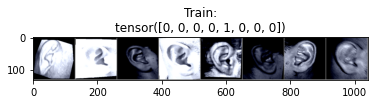

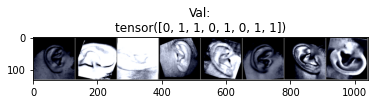

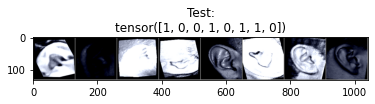

In [5]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images), f"Train:\n{labels}" )

images, labels = iter(val_loader).next()
imshow(torchvision.utils.make_grid(images), f"Val:\n{labels}" )

images, labels = iter(test_loader).next()
imshow(torchvision.utils.make_grid(images), f"Test:\n{labels}" )

## Definitions

### CNN definition

In [6]:
# Creating a CNN class
class SpoofDetectionNetwork(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, l1=64, l2=16):
        # Also found with __init__(self, input_dimension, output_dimension)
        super(SpoofDetectionNetwork, self).__init__()
        
        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.batchNorm1 = nn.BatchNorm2d(32)
        
        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.batchNorm2 = nn.BatchNorm2d(64)
        
        # Layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.relu3 = nn.ReLU()
        self.max_pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.batchNorm3 = nn.BatchNorm2d(64)
        
        # Layer 4
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3)
        self.relu4 = nn.ReLU()
        self.max_pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.batchNorm4 = nn.BatchNorm2d(96)
        
        # Layer 5
        self.conv5 = nn.Conv2d(in_channels=96, out_channels=32, kernel_size=3)
        self.relu5 = nn.ReLU()
        self.max_pool5 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.batchNorm5 = nn.BatchNorm2d(32)
        
        # After convolution layers
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128, l1)
        self.fc_relu1 = nn.ReLU()
        self.fc2 = nn.Linear(l1, l2)
        self.fc_relu2 = nn.ReLU()
        self.fc3 = nn.Linear(l2, 1)
        self.fc_sigmoid = nn.Sigmoid()
    
    # Progresses data across layers    
    def forward(self, x):
        # Layer 1
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.max_pool1(out)
        out = self.batchNorm1(out)
        
        # Layer 2
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.max_pool2(out)
        out = self.batchNorm2(out)
        
        # Layer 3
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.max_pool3(out)
        out = self.batchNorm3(out)
        
        # Layer 4
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.max_pool4(out)
        out = self.batchNorm4(out)
        
        # Layer 5
        out = self.conv5(out)
        out = self.relu5(out)
        out = self.max_pool5(out)
        out = self.batchNorm5(out)
        
        out = self.dropout(out)
        out = out.reshape(out.size(0), -1)
        
        out = self.fc_relu1(self.fc1(out))
        out = self.fc_relu2(self.fc2(out))
        out = self.fc_sigmoid(self.fc3(out))

        return out

### Training definition

In [7]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.improved = False

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            print(f"New best loss {validation_loss:.10f}, was: {self.min_validation_loss:.10f}")
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.improved = True
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            print(f"Val_Loss: {validation_loss}; Threshold: {self.min_validation_loss + self.min_delta}")
            self.counter += 1
            self.improved = False
            if self.counter >= self.patience:
                return True
        else:
            print("Within delta")
            self.improved = False
        return False
# based one: https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch

In [8]:
model = SpoofDetectionNetwork()
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)
best_model = None

# store losses to plot later
val_losses = []
train_losses = []
    
# Set Loss function with criterion
criterion = nn.BCELoss().to(device)
# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
total_step = len(train_loader)

# Init the early stopper
early_stopper = EarlyStopper(patience=es_patience, min_delta=es_min_delta)
actual_epochs = 0

## Training ##

In [9]:
print("Start training")
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
    #Load in the data in batches using the train_loader object
    # Training
    epoch_train_loss = []
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        labels = labels.unsqueeze(1).float()

        criterion.weight = labels * w_spoof + (1-labels)*w_real
        loss = criterion(outputs, labels)

        '''
        Example labels
        tensor([[0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.]], device='cuda:0')
        
        Example weights for this tensor
        tensor([[0.3000],
        [0.7000],
        [0.3000],
        [0.3000],
        [0.3000],
        [0.7000],
        [0.7000],
        [0.3000]], device='cuda:0')
        '''
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss.append(loss.item())
            
    train_losses.append(sum(epoch_train_loss)/len(epoch_train_loss))
        
     # Validation loss
    epoch_val_loss = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).int()

            outputs = model(inputs)
            predicted = torch.flatten(torch.round(outputs)).int()
            labels = labels.unsqueeze(1).float()

            criterion.weight = labels * w_spoof + (1-labels)*w_real
            loss = criterion(outputs, labels)
            
            epoch_val_loss.append(loss.item())
    
    val_losses.append(sum(epoch_val_loss)/len(epoch_val_loss))

    print('Epoch [{}/{}], Train-Loss: {:.4f}, Val-Loss: {:.4f}'.format(epoch+1, num_epochs, sum(epoch_train_loss)/len(epoch_train_loss), sum(epoch_val_loss)/len(epoch_val_loss)))
    actual_epochs = epoch+1
    # Run early stopper and check whether to break
    if early_stopper.early_stop(sum(epoch_val_loss)/len(epoch_val_loss)):     
        print(f"Early stop of training in epoch {epoch+1}, values did not decrease sufficiently anymore")
        model = best_model
        break
        
    if early_stopper.improved:
        print("Copy new best model")
        best_model = deepcopy(model)

Start training
Epoch [1/50], Train-Loss: 0.2902, Val-Loss: 0.2172
New best loss 0.2171849401, was: inf
Copy new best model
Epoch [2/50], Train-Loss: 0.1709, Val-Loss: 0.1292
New best loss 0.1292139541, was: 0.2171849401
Copy new best model
Epoch [3/50], Train-Loss: 0.1036, Val-Loss: 0.0946
New best loss 0.0946253810, was: 0.1292139541
Copy new best model
Epoch [4/50], Train-Loss: 0.0912, Val-Loss: 0.0879
New best loss 0.0879418914, was: 0.0946253810
Copy new best model
Epoch [5/50], Train-Loss: 0.0789, Val-Loss: 0.0636
New best loss 0.0635644958, was: 0.0879418914
Copy new best model
Epoch [6/50], Train-Loss: 0.0604, Val-Loss: 0.0712
Val_Loss: 0.0712301968486004; Threshold: 0.06856449581549637
Epoch [7/50], Train-Loss: 0.0581, Val-Loss: 0.0587
New best loss 0.0586622781, was: 0.0635644958
Copy new best model
Epoch [8/50], Train-Loss: 0.0425, Val-Loss: 0.0406
New best loss 0.0405994079, was: 0.0586622781
Copy new best model
Epoch [9/50], Train-Loss: 0.0379, Val-Loss: 0.0325
New best los

36


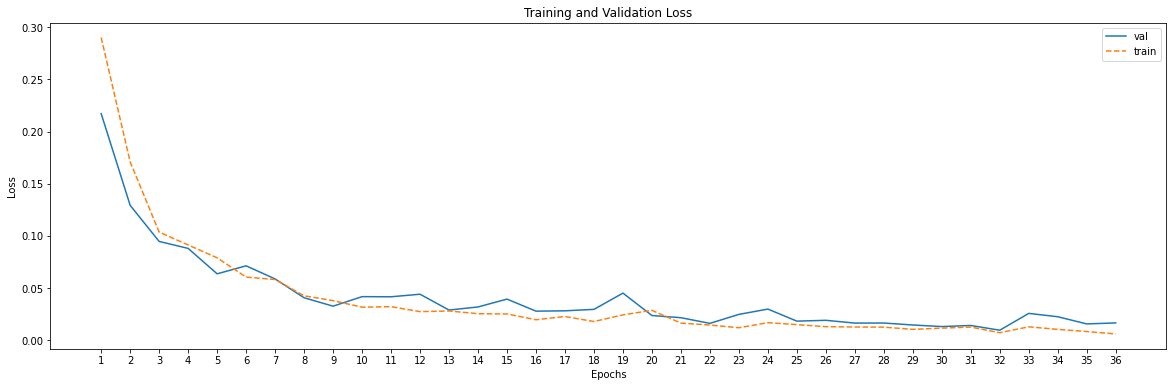

In [10]:
print(actual_epochs)
plt.figure(figsize=(20,6))
plt.title("Training and Validation Loss")
plt.plot(range(1,actual_epochs+1), val_losses,label="val", linestyle = 'solid')
plt.plot(range(1,actual_epochs+1), train_losses,label="train", linestyle = 'dashed')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(range(1,actual_epochs+1))
plt.legend();

## Evaluation 

Predicted labels 


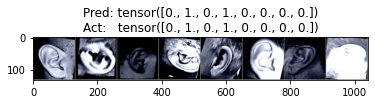

In [11]:
# Test image batch with predicted outputs and the pictures
dataiter = iter(test_loader)
images, labels = dataiter.next()

outputs = model(images.to(device))
with torch.no_grad():
    predicted = torch.flatten(torch.round(outputs)).float()
    # show images
    print("Predicted labels ")
    imshow(torchvision.utils.make_grid(images.cpu()), f"Pred: {predicted.cpu()}\nAct:   {labels.float()}" )

In [12]:
# Testing
with torch.no_grad():
    n_dif = 0
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(num_classes)]
    n_class_samples = [0 for i in range(num_classes)]

    for images, labels in test_loader: # number of elements defined by batch size
        images = images.to(device)
        labels = labels.to(device).int()
        outputs = model(images)

        predicted = torch.flatten(torch.round(outputs)).int()
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(labels.size(dim=-1)):
            label = labels[i]
            pred = predicted[i]
            n_class_samples[label] += 1
            if (label == pred):
                n_class_correct[label] += 1
            else:
                if (n_dif < (n_class_samples[label]-n_class_correct[label])):
                    #imshow(torchvision.utils.make_grid(images.cpu()), f"Pred: {predicted.cpu().float()}\nAct:   {labels.cpu().float()}" )
                    n_dif += 1
    
    t = PrettyTable(['Class', 'Accuracy'])

    acc = 100.0 * n_correct / n_samples
    t.add_row(['Overall', f"{acc:.2f}%"])

    for i in range(num_classes):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        t.add_row([dataset.classes[i], f"{acc:.2f}%"])
            
    print(t)

+---------+----------+
|  Class  | Accuracy |
+---------+----------+
| Overall |  98.56%  |
|   Real  |  98.01%  |
|  Spoof  |  99.21%  |
+---------+----------+


## Save Model to file ##

In [13]:
filename = f'model_{fcl1}_{fcl2}_{batch_size}_{learning_rate}_{es_patience}_{es_min_delta}_{w_spoof:.3f}.h5'
torch.save(model.state_dict(), f'/kaggle/working/{filename}')

In [8]:
# delete old model files
import os
entries = os.listdir('/kaggle/working/')
for entry in entries:
    print(entry)

model_32_16_8_0.001_4_0.005_0.498.h5
.virtual_documents
__notebook_source__.ipynb


In [7]:
#os.remove("/kaggle/working/model_32_16_8_0.0025_4_0.005_0.498.h5")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/model_32_16_8_0.0025_4_0.005_0.498.h5'